<a href="https://colab.research.google.com/github/lmlima/PoolAttendance/blob/master/Apresenta%C3%A7%C3%A3o_Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Dependências

Foram usadas as bibliotecas:
- Pandas
- Bokeh
- Keras + Tensorflow
- Scikit-learn

- Numpy
- Datetime
- OS

In [0]:
#@title Instalando dependências
#install TensorFlow 2.0 alpha version
!pip install tensorflow==2.0.0-alpha0
# !pip install 'matplotlib<=3.1.0'
!pip install matplotlib==3.2.0rc1


!pip install bokeh
!pip install pandas-bokeh


# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook

# multivariate one step problem with lstm
import tensorflow as tf
import os
import datetime

from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Validação
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor

import pandas as pd
%load_ext google.colab.data_table
import bokeh
import seaborn as sns
import pandas_bokeh
pandas_bokeh.output_notebook()

     |████████████████████████████████| 79.9MB 44kB/s 
     |████████████████████████████████| 419kB 56.8MB/s 
     |████████████████████████████████| 3.0MB 38.1MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 12.4MB 144kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.2
    Uninstalling matplotlib-3.1.2:
      Successfully uninstalled matplotlib-3.1.2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

# 2. Base de dados

## 2.1. Define a base de dados

- Apresentar e fazer uma breve analise da base de dados

In [0]:
pool_name = "Sunset"
# pool_name = "McCarren"

df_poolsize = pd.read_csv("https://raw.githubusercontent.com/lmlima/PoolAttendance/master/data/pool_size.csv")

df = pd.read_csv("https://raw.githubusercontent.com/lmlima/PoolAttendance/master/data/ospa-completo.csv")
df.head()

df_orig = df.copy()
df_few_orig = df_orig[df_orig.Pool == pool_name].drop(columns="Pool")

# input_col = ["Attendance", "Daily Data Temperaturemin", "Daily Data Temperaturemax"]
input_col = ["Attendance", "Daily Data Temperaturehigh", "Daily Data Temperaturemax", "Daily Data Apparenttemperaturehigh", "Daily Data Apparenttemperaturemax", "Daily Data Temperaturelow", "Daily Data Apparenttemperaturelow", "Daily Data Uvindex", "Daily Data Apparenttemperaturemin", "Daily Data Temperaturemin", "Daily Data Windbearing", "Daily Data Dewpoint", "Daily Data Moonphase"]
df_few = df_few_orig[input_col]

# Adicionar a previsao do dia seguinte
df_few["Daily Data Apparenttemperaturemax -1"] = df_few_orig["Daily Data Apparenttemperaturemax"].shift(-1)
df_few["Daily Data Apparenttemperaturemin  -1"] = df_few_orig["Daily Data Apparenttemperaturemin"].shift(-1)

df_few = df_few.reset_index(drop=True)

df_dataset = df_few.copy()
df_target = df_few[["Attendance"]].copy()
df_dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Attendance,Daily Data Temperaturehigh,Daily Data Temperaturemax,Daily Data Apparenttemperaturehigh,Daily Data Apparenttemperaturemax,Daily Data Temperaturelow,Daily Data Apparenttemperaturelow,Daily Data Uvindex,Daily Data Apparenttemperaturemin,Daily Data Temperaturemin,Daily Data Windbearing,Daily Data Dewpoint,Daily Data Moonphase,Daily Data Apparenttemperaturemax -1,Daily Data Apparenttemperaturemin -1
0,2124,79.92,79.92,79.42,79.42,64.24,64.73,8,58.72,58.23,285,51.94,0.18,84.67,64.73
1,2684,83.84,83.84,84.67,84.67,71.68,72.56,9,64.73,64.24,206,60.68,0.22,94.88,72.56
2,1377,90.25,90.25,94.88,94.88,72.71,74.21,8,72.56,71.68,213,66.49,0.25,87.84,72.47
3,3138,82.99,82.99,87.84,87.84,70.72,72.43,6,72.47,70.82,186,70.68,0.28,90.38,72.43
4,1432,89.26,89.26,90.38,90.38,69.16,70.22,9,72.43,70.72,255,66.98,0.31,88.68,70.22


In [0]:
# Piscinas
print(df["Pool"].unique())
print(df["Pool"].nunique())

# for c in df_dataset.columns:
#   df_dataset[[c]].plot_bokeh(rangetool=True)
df_dataset[["Attendance"]].plot_bokeh(rangetool=True)
df_dataset[["Daily Data Temperaturemax"]].plot_bokeh(rangetool=True)


['Betsy Head' 'Adelphi' 'Lindower Mill Basin' 'Jesse Owens JHS 57'
 'Glenwood' 'David Fox' 'McCarren' 'Sunset' 'Red Hook' 'Kosciusko'
 'Howard' 'Douglas Degraw' 'Commodore Barry' 'Bushwick' 'Claremont'
 'Edenwald Houses' 'Crotona' 'Floating Pool' 'Haffen' 'Mapes' 'Mullaly'
 'Van Cortlandt' 'Bronx River Plgd' 'Asser Levy' 'Dapolito' 'Dry Dock'
 'Hamilton Fish' 'Highbridge' 'Jackie Robinson' 'John Jay' 'Lasker'
 'Marcus Garvey' 'Sheltering Arms' 'Thomas Jefferson' 'Wagner'
 'Abe Lincoln' 'Fred Douglass' 'Vesuvio' 'Tompkins Sq' 'Astoria' 'Fisher'
 'Liberty' 'Fort Totten' 'Marie Curie' 'Astoria Hts PS 10'
 'Castlewood PS 186' 'Windmuller' 'Faber' 'Lyons' 'Tottenville'
 'West Brighton' 'MacArthur' "Mariner's Harbor" 'P.S. 14' 'P.S. 46']
55


Column(id='1237', ...)

Analise da correlação entre as séries temporais

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20) # (w, h)

df_corr = df_few.corr()["Attendance"]

# grafico_corr = sns.heatmap(df_corr, annot=True, cmap="YlGnBu")
# grafico_corr.set_xticklabels(grafico_corr.get_xticklabels(), rotation=45)
df_corr.map('{:,.2f}'.format).sort_values(ascending=False)
# df_corr.sort_values(ascending=False)

Attendance                               1.00
Daily Data Apparenttemperaturemax -1     0.60
Daily Data Temperaturemax                0.47
Daily Data Temperaturehigh               0.47
Daily Data Apparenttemperaturemax        0.42
Daily Data Apparenttemperaturehigh       0.42
Daily Data Apparenttemperaturemin  -1    0.39
Daily Data Temperaturelow                0.37
Daily Data Apparenttemperaturelow        0.35
Daily Data Temperaturemin                0.32
Daily Data Apparenttemperaturemin        0.32
Daily Data Uvindex                       0.31
Daily Data Dewpoint                      0.25
Daily Data Moonphase                     0.21
Daily Data Windbearing                   0.20
Name: Attendance, dtype: object

Visualização da distribuição em relação a uma das piscinas

In [0]:
# Data stats

print(F"Descrição da piscina {pool_name}")
df_few.describe()

Descrição da piscina Sunset


,Attendance,Daily Data Temperaturehigh,Daily Data Temperaturemax,Daily Data Apparenttemperaturehigh,Daily Data Apparenttemperaturemax,Daily Data Temperaturelow,Daily Data Apparenttemperaturelow,Daily Data Uvindex,Daily Data Apparenttemperaturemin,Daily Data Temperaturemin,Daily Data Windbearing,Daily Data Dewpoint,Daily Data Moonphase,Daily Data Apparenttemperaturemax -1,Daily Data Apparenttemperaturemin -1
count,149.000000,149.00000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,148.000000,148.000000
mean,1189.228188,83.01047,83.102617,85.174161,85.278188,68.119597,69.280940,6.993289,68.933624,67.825503,196.973154,64.656174,0.510067,85.317770,69.002635
std,978.061729,6.55782,6.429358,8.714471,8.585287,5.643695,6.138214,1.694573,5.892609,5.440345,83.870472,6.528486,0.268880,8.600786,5.851890
min,0.000000,67.13000,67.130000,66.630000,66.630000,51.940000,52.430000,4.000000,52.430000,51.940000,21.000000,43.550000,0.010000,66.630000,52.430000
25%,445.000000,78.86000,78.860000,78.450000,78.750000,64.880000,65.580000,6.000000,64.730000,64.240000,153.000000,60.180000,0.290000,78.725000,65.097500
50%,1004.000000,83.70000,83.700000,84.880000,84.880000,68.740000,69.870000,7.000000,69.730000,68.580000,203.000000,65.170000,0.510000,85.115000,69.745000
75%,1707.000000,88.22000,88.220000,91.220000,91.220000,72.710000,74.340000,8.000000,73.830000,71.990000,262.000000,70.210000,0.720000,91.252500,73.837500
max,4808.000000,95.54000,95.540000,103.590000,103.590000,78.020000,81.460000,10.000000,79.750000,78.020000,354.000000,74.070000,1.000000,103.590000,79.750000


In [0]:
###
# Pool datset
###
dataset = df_dataset.to_numpy()
target = df_target.to_numpy()
# print(dataset_example)
# print(dataset)

## 2.2. Preparo dos dados para a predição




Formato dos dados para a entrada na rede LSTM
<img src="https://cdn-images-1.medium.com/freeze/max/1000/1*v5_QpzkQfufVogeCY9eaOw.png?q=20" alt="Drawing" width="400"/>

In [0]:
# define generator
n_features = dataset.shape[1]
n_output = target.shape[1]
data_length = len(target)

window_size = 7

# Visualização
print(F"Número de características de entrada: {n_features}")
print(F"Número de características de saída: {n_output}\n")

print(F"Janela de avaliação: {window_size}")
print(F"Tamanho dos dados: {data_length}")
print(F"Tamanho dos batches: {data_length}")

# Usar o TSGenerator para moldar os dados
generator = TimeseriesGenerator(dataset, target, length=window_size, batch_size=data_length)
X = generator[0][0]
Y = generator[0][1]

# print(F"X: {X[:3]}")
# print(F"Y: {Y[:3]}")

Número de características de entrada: 15
Número de características de saída: 1

Janela de avaliação: 7
Tamanho dos dados: 149
Tamanho dos batches: 149


# 3. Modelo



## 3.1. Arquitetura do modelo


As computações derivadas da entrada anterior são realimentadas na rede, o que lhes dá um tipo de memória.

Um tipo de rede neural recorrente é a arquitetura LSTM (“Long Short Term Memory”), também chamada de “redes de memória de longo prazo”.

Cada célula da LSTM, recebe duas entradas: a saída do último estado oculto e a observação no tempo = t.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" alt="Drawing" width="600"/>

O modelo proposto inicialmente possui as seguintes camadas:
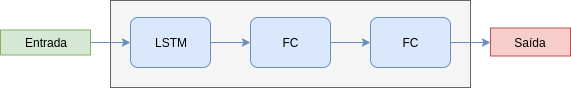


In [0]:
#@title
def mlp_model(): 
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(n_features,)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(n_output))

  lr = 2e-6
  # decay = 1e-2
  adam_opt = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(optimizer=adam_opt, loss='mse', metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError()])
  return model

In [0]:
# define model
def lstm_model(): 
  # Arquitetura
  model = Sequential()
  model.add(LSTM(128, activation='relu', input_shape=(window_size, n_features)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(n_output))

  # Otimizador
  # lr = 2e-6
  lr = 2e-5
  adam_opt = tf.keras.optimizers.Adam(learning_rate=lr)

  # Métricas e definição do modelo
  model.compile(optimizer=adam_opt, loss='mae', metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError()])

  return model



In [0]:
model = lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 128)               73728     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 86,209
Trainable params: 86,209
Non-trainable params: 0
_________________________________________________________________


## 3.2. Treinamento
- Apresentar os hiperparâmetros e pq
- Visualizar treinamento

In [0]:
# Configuração do Tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
#@title Visualizar treinamento
%tensorboard --logdir logs

In [0]:
# fit model
# n_epochs = 1500
n_epochs = 200

n_batch = 64
validation_perc = 0.3
model = lstm_model()

model.fit(X, Y, batch_size=n_batch, validation_split=validation_perc, epochs=n_epochs, callbacks=[tensorboard_callback], verbose=1)

Train on 99 samples, validate on 43 samples
Epoch 1/200
99/99 [==============================] - 2s 16ms/sample - loss: 1244.2158 - mae: 1244.2157 - mse: 2604213.7500 - root_mean_squared_error: 1613.7577 - val_loss: 1159.4318 - val_mae: 1159.4318 - val_mse: 2025713.1250 - val_root_mean_squared_error: 1423.2755
Epoch 2/200
99/99 [==============================] - 0s 790us/sample - loss: 1237.6370 - mae: 1237.6370 - mse: 2585733.2500 - root_mean_squared_error: 1608.0215 - val_loss: 1157.4771 - val_mae: 1157.4771 - val_mse: 2022145.5000 - val_root_mean_squared_error: 1422.0216
Epoch 3/200
99/99 [==============================] - 0s 759us/sample - loss: 1235.2091 - mae: 1235.2091 - mse: 2578712.2500 - root_mean_squared_error: 1605.8369 - val_loss: 1156.4841 - val_mae: 1156.4841 - val_mse: 2019950.1250 - val_root_mean_squared_error: 1421.2495
Epoch 4/200
99/99 [==============================] - 0s 738us/sample - loss: 1232.5966 - mae: 1232.5966 - mse: 2571637.5000 - root_mean_squared_error:

# 4. Cálculo de salva vidas
Calcula o número de salva vidas necessário

In [0]:
pred_x = X[96:97]
y_real = int(Y[96:97])

print(y_real)
print(F"Entrada:\n{pred_x}")

y_pred = int(model.predict(pred_x))

print(F"Presença real: {y_real}\nPresença predita: {y_pred}\nDiferença: {y_real-y_pred}")

685
Entrada:
[[[8.860e+02 8.417e+01 8.417e+01 8.367e+01 8.367e+01 6.304e+01 6.353e+01
   9.000e+00 6.758e+01 6.695e+01 3.480e+02 5.900e+01 2.200e-01 8.152e+01
   6.353e+01]
  [0.000e+00 8.202e+01 8.202e+01 8.152e+01 8.152e+01 6.452e+01 6.542e+01
   1.000e+01 6.353e+01 6.304e+01 9.400e+01 5.357e+01 2.600e-01 8.127e+01
   6.542e+01]
  [7.460e+02 8.113e+01 8.113e+01 8.127e+01 8.127e+01 6.631e+01 6.680e+01
   7.000e+00 6.542e+01 6.452e+01 1.580e+02 5.998e+01 2.900e-01 7.581e+01
   6.674e+01]
  [6.550e+02 7.631e+01 7.631e+01 7.581e+01 7.581e+01 6.559e+01 6.674e+01
   7.000e+00 6.674e+01 6.559e+01 9.700e+01 5.951e+01 3.200e-01 8.488e+01
   7.048e+01]
  [8.100e+02 8.076e+01 8.076e+01 8.488e+01 8.488e+01 7.398e+01 7.607e+01
   5.000e+00 7.048e+01 6.894e+01 1.390e+02 7.144e+01 3.500e-01 8.636e+01
   7.580e+01]
  [8.890e+02 8.162e+01 8.162e+01 8.636e+01 8.636e+01 7.526e+01 7.730e+01
   5.000e+00 7.580e+01 7.376e+01 1.530e+02 7.344e+01 3.800e-01 8.917e+01
   7.730e+01]
  [1.760e+02 8.370e+01 8.37

In [0]:
import math
def NumSalvaVidasSup( attendance, Areapool):
    if Areapool < 3400:
        salvaVidasSup = math.ceil(attendance/75)
    elif Areapool >= 3400:
        salvaVidasSup = math.ceil(Areapool/3400)
        if 1.5*(Areapool/25) < attendance:
           salvaVidas1=salvaVidasSup+1
    if salvaVidasSup<1:
        salvaVidasSup=1
    return salvaVidasSup

pool_size = df_poolsize[df_poolsize.Pool == pool_name]["Size"].values

nsv_real = NumSalvaVidasSup(y_real,pool_size)
nsv_pred = NumSalvaVidasSup(y_pred,pool_size)

print(F"Piscina {pool_name}\nSalva vidas Supervisores real : {nsv_real}\nSalva vidas Supervisores predito: {nsv_pred}\nDiferença: {nsv_real-nsv_pred}")

Piscina Sunset
Salva vidas Supervisores real : 13
Salva vidas Supervisores predito: 13
Diferença: 0


In [0]:
import math
def NumSalvaVidas( attendance, Areapool):
    salvaVidas = math.ceil(attendance/25) + math.ceil(Areapool/3400)

    if salvaVidas<1:
        salvaVidas=1
    return salvaVidas

pool_size = df_poolsize[df_poolsize.Pool == pool_name]["Size"].values

nsv_real = NumSalvaVidas(y_real,pool_size)
nsv_pred = NumSalvaVidas(y_pred,pool_size)

print(F"Piscina {pool_name}\nSalva vidas real: {nsv_real}\nSalva vidas predito: {nsv_pred}\nDiferença: {nsv_real-nsv_pred}")

Piscina Sunset
Salva vidas real: 41
Salva vidas predito: 15
Diferença: 26
